# Improving previous machine learning models

In the previous [notebook](https://github.com/olinguyen/gsoc2017-shogun-dataproject/blob/master/Model%20%26%20Prediction.ipynb), we built simple models for predicting mortality and the hospital length of stay. Let's recall that only demographic data and simple vital signs e.g. heartrate, respiratory rate and blood pressure were used. In this notebook, we'll extract a lot more features from the patient data to improve our models. In addition to demographic data, we'll extract more vital signs and include laboratory measurements from the patients. These measurements were obtained by analyzing a fluid from the patient (either blood or urine sample).

Since we now have a lot more data to extract, we'll split the data into different tables and use materialized views, which are tables that are physically stored on disk. This allows to make our queries much faster and test out different variables.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from scipy.stats import ks_2samp
from scipy import interp
from modshogun import *
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
import time

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

from xgboost import XGBClassifier

%matplotlib inline
plt.style.use('ggplot')

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# SQL database config
sqluser = ''
dbname = 'MIMIC3'
schema_name = 'mimiciii'
hostname = ''
port = 5432
pwd = getpass.getpass()

········


In [35]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=5432, password=pwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [120]:
query = \
"""
-- Table #3: Services
with serv AS
(
SELECT icu.hadm_id, icu.icustay_id, se.curr_service
, CASE
    WHEN curr_service like '%SURG' then 1
    WHEN curr_service = 'ORTHO' then 1
    ELSE 0 END
  as surgical
, RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
FROM icustays icu
LEFT JOIN services se
 ON icu.hadm_id = se.hadm_id
AND se.transfertime < icu.intime + interval '12' hour
)

-- Table #4: Clinical data + demographics
, co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, first_careunit, admission_type
, icu.los as icu_los
, round((EXTRACT(EPOCH FROM (adm.dischtime-adm.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age_icu_in
, pat.gender
, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
, hospital_expire_flag
, CASE WHEN pat.dod IS NOT NULL 
       AND pat.dod >= icu.intime - interval '6 hour'
       AND pat.dod <= icu.outtime + interval '6 hour' THEN 1 
       ELSE 0 END AS icu_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '30' day THEN 1 
    ELSE 0 END as hospital30day_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '1' year THEN 1 
    ELSE 0 END as hospital1year_expire_flag      
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
INNER JOIN admissions adm
ON adm.hadm_id = icu.hadm_id    
)

-- Table #5: Exclusions
, excl AS
(
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_los, co.hosp_los
  , co.age_icu_in
  , co.gender
  , co.icustay_id_order
  , serv.curr_service
  , co.first_careunit
  , co.hospital_expire_flag
  , co.icu_expire_flag
  , CASE
        WHEN co.icu_los < 1 then 1
    ELSE 0 END
    AS exclusion_los
  , CASE
        WHEN co.age_icu_in < 16 then 1
    ELSE 0 END
    AS exclusion_age
  , CASE 
        WHEN co.icustay_id_order != 1 THEN 1
    ELSE 0 END 
    AS exclusion_first_stay
  , CASE
        WHEN serv.surgical = 1 THEN 1
    ELSE 0 END
    as exclusion_surgical
FROM co
LEFT JOIN serv
  ON  co.icustay_id = serv.icustay_id
  AND serv.rank = 1
)

SELECT vital.icustay_id, vital.subject_id, vital.hadm_id
-- vital signs for the first 24 hours of the icu stay
, HeartRate_Min
, HeartRate_Mean
, HeartRate_Max
, DiasBP_Min
, DiasBP_Max
, SysBP_Min
, SysBP_Max
, MeanBP_Min
, MeanBP_Mean
, MeanBP_Max
, RespRate_Min
, RespRate_Mean
, RespRate_Max
, TempC_Min
, TempC_Max
, SpO2_Min
, SpO2_Max

-- Glasgow coma score
, MinGCS
, GCSMotor
, GCSVerbal
, GCSEyes

-- lab values
, ANIONGAP_min
, ANIONGAP_max
, ALBUMIN_min
, ALBUMIN_max
, BANDS_min
, BANDS_max
, BICARBONATE_min
, BICARBONATE_max
, BILIRUBIN_min
, BILIRUBIN_max
, CREATININE_min
, CREATININE_max
, CHLORIDE_min
, CHLORIDE_max
, lab.GLUCOSE_min
, lab.GLUCOSE_max
, HEMATOCRIT_min
, HEMATOCRIT_max
, HEMOGLOBIN_min
, HEMOGLOBIN_max
, LACTATE_min
, LACTATE_max
, PLATELET_min
, PLATELET_max
, POTASSIUM_min
, POTASSIUM_max
, PTT_min
, PTT_max
, INR_min
, INR_max
, PT_min
, PT_max
, SODIUM_min
, SODIUM_max
, BUN_min
, BUN_max
, WBC_min
, WBC_max

, urineoutput

-- whether the patient is ventilated on the first day of the ICU stay
, vent

-- demographic data
, co.age_icu_in, co.first_careunit, co.gender, co.admission_type
, hw.height_first, hw.weight_first

-- outcomes
, co.hospital_expire_flag, co.icu_expire_flag
, co.hosp_los, co.icu_los, co.icustay_id_order
, co.hospital1year_expire_flag, hospital30day_expire_flag

-- exclusions
, excl.exclusion_los, excl.exclusion_age
, excl.exclusion_first_stay, excl.exclusion_surgical

FROM mimiciii_dev.vitalsfirstday vital
LEFT JOIN mimiciii_dev.labsfirstday lab
  ON vital.icustay_id = lab.icustay_id
LEFT JOIN mimiciii_dev.gcsfirstday gcs
  ON vital.icustay_id = gcs.icustay_id
LEFT JOIN mimiciii_dev.uofirstday uo
  ON vital.icustay_id = uo.icustay_id
LEFT JOIN mimiciii_dev.ventfirstday vent
  ON vital.icustay_id = vent.icustay_id
left join co
  ON vital.icustay_id = co.icustay_id
left join public.heightweight hw
  ON vital.icustay_id = hw.icustay_id
left join excl
  on vital.icustay_id = excl.icustay_id;
"""

query_output = pd.read_sql_query(query,con) #.dropna().reset_index(drop=True)
query_output.head()

,icustay_id,subject_id,hadm_id,heartrate_min,heartrate_mean,heartrate_max,diasbp_min,diasbp_max,sysbp_min,sysbp_max,...,icu_expire_flag,hosp_los,icu_los,icustay_id_order,hospital1year_expire_flag,hospital30day_expire_flag,exclusion_los,exclusion_age,exclusion_first_stay,exclusion_surgical
0,263738,13,143045,60.0,83.600000,124.0,53.0,84.0,102.0,151.0,...,0,6.8556,3.6660,1,0,0,0,0,0,0
1,211832,71,111944,98.0,112.444444,137.0,31.0,130.0,94.0,157.0,...,0,4.6618,2.8609,1,0,0,0,0,0,0
2,233150,78,100536,56.0,63.117647,73.0,78.0,119.0,134.0,206.0,...,0,3.9139,1.4891,1,0,0,0,0,0,0
3,233111,101,175533,72.0,87.034483,117.0,19.0,85.0,57.0,182.0,...,0,15.7785,9.8919,1,1,1,0,0,0,0
4,212246,103,130744,42.0,51.500000,60.0,40.0,71.0,112.0,161.0,...,0,7.7347,3.0237,1,1,1,0,0,0,1


In [121]:
query_output.to_csv('./full-features-materialized.csv', index=False)

## First lab measurement visualization

To get a better idea of how laboratory measurements for patients admitted to the ICU, we'll plot the distribution of measurements for survival and non-survival groups for various lab measurements. Normal range for the lab measurements can be seen below which have a lower and upper limit, taken from this [notebook](https://github.com/MIT-LCP/mimic-code/blob/master/notebooks/first_labs.ipynb). 

| Lab Value      | Lower limit | Upper Limit | Units  |
|----------------|-------------|-------------|--------|
| Bicarbonate    | 22          | 32          | mEq/L  |
| BUN            | 6           | 20          | mEq/L  |
| Calcium        | 8.4         | 10.3        | mg/dL  |
| Chloride       | 96          | 108         | mEq/L  |
| Creatinine     | 0.4         | 1.1         | mEq/L  |
| Hemoglobin     | 11.2        | 15.7        | g/dL   |
| Lactate        | 0.5         | 2           | mmol/L |
| Magnesium      | 1.6         | 2.6         | mg/dL  |
| Phosphate      | 2.7         | 4.5         | mg/dL  |
| Platelet count | 150         | 400         | K/uL   |
| Potassium      | 3.3         | 5.1         | mEq/L  |
| Sodium         | 133         | 145         | mEq/L  |

In [165]:
# Create dictionary of ranges
# Keys should match the lab names in the query below
# Are these values correct given the units? Need to check.

lab_ranges = {'BICARBONATE': [22,32],
              'BUN': [6,20],
              'CALCIUM': [8.4,10.3],
              'CHLORIDE': [96,108],
              'CREATININE': [0.4,1.1],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145]
             }

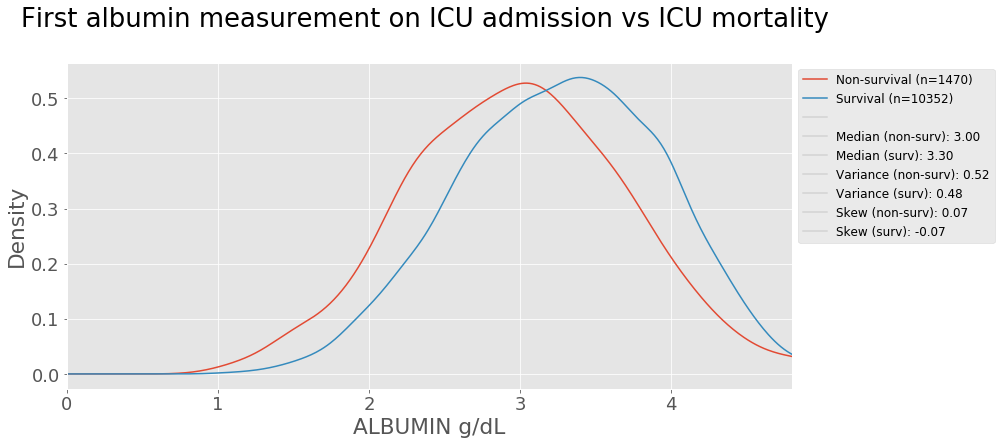

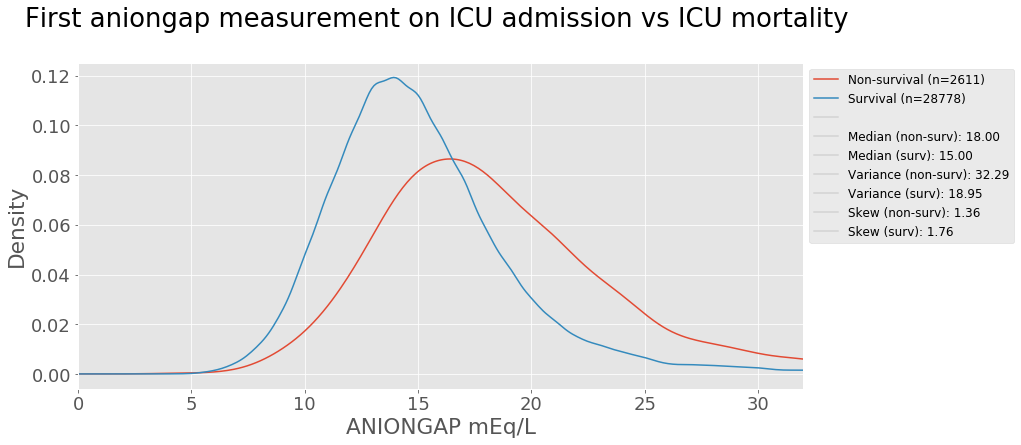

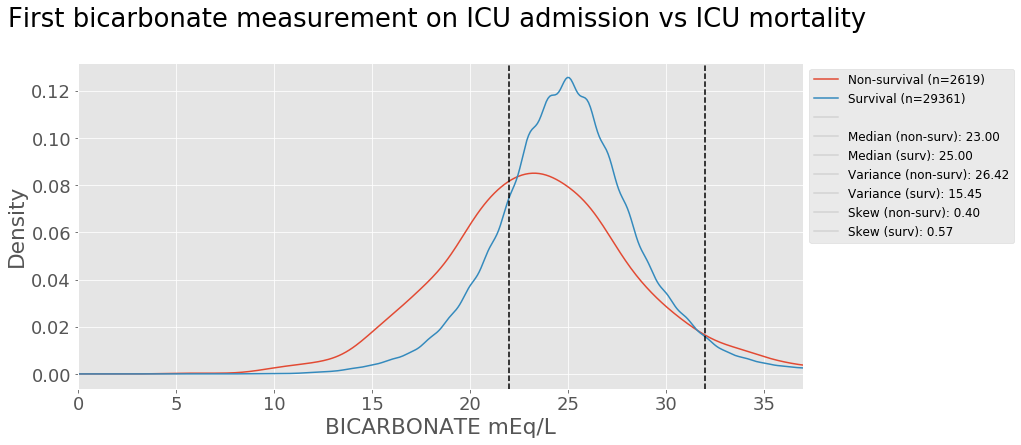

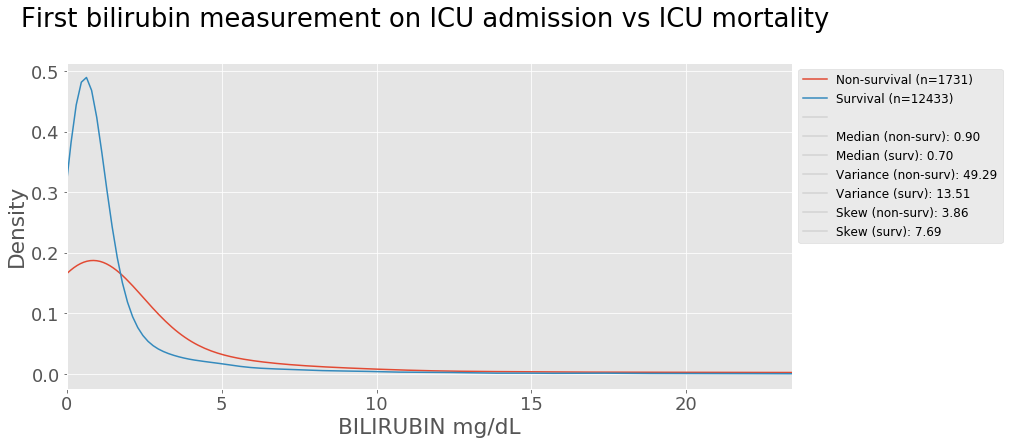

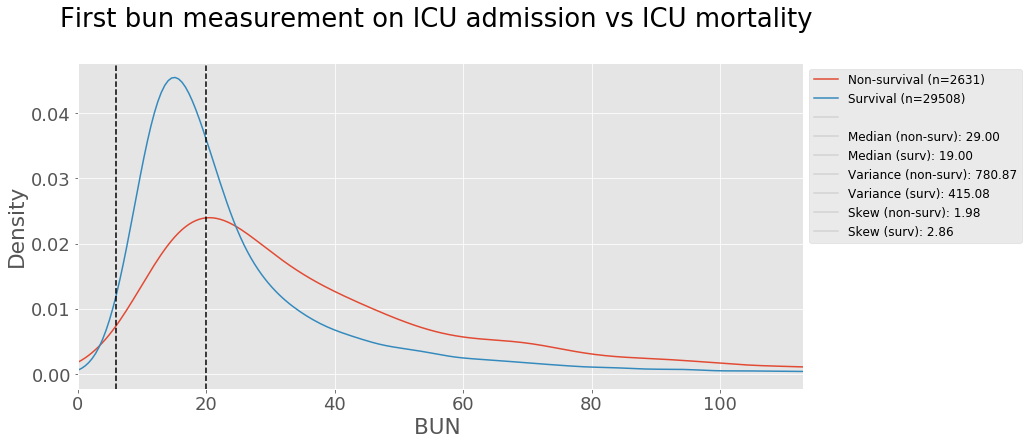

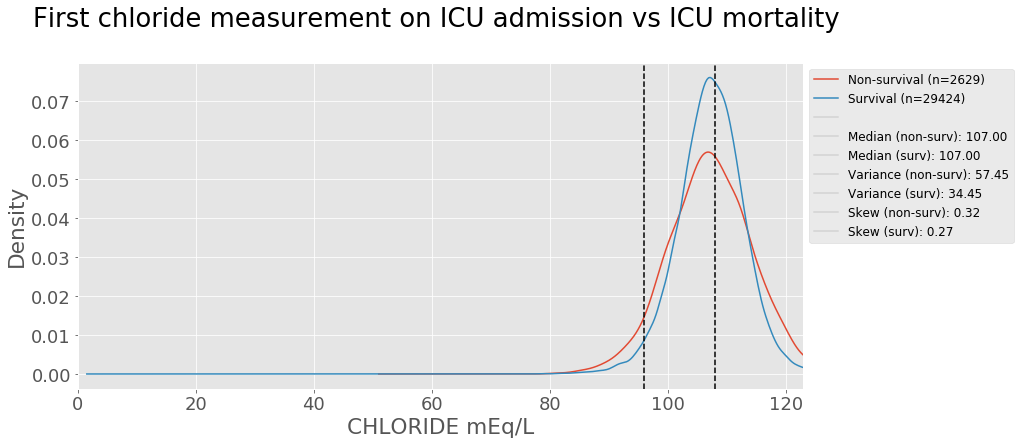

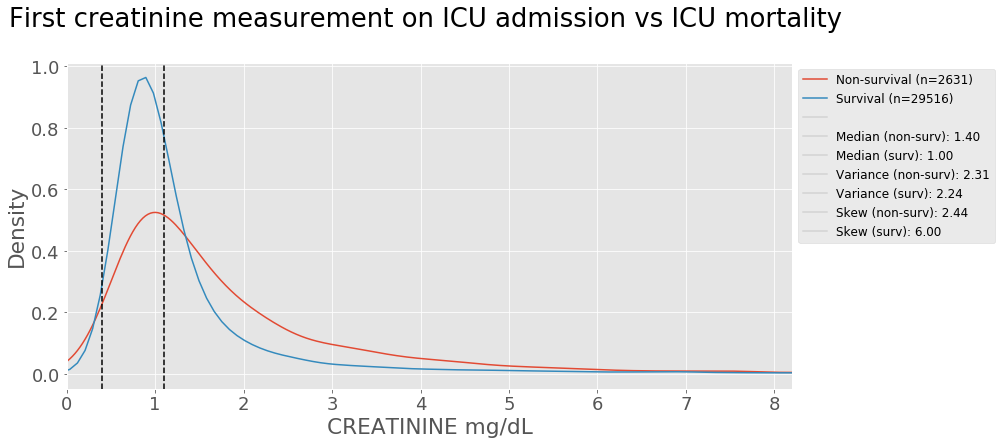

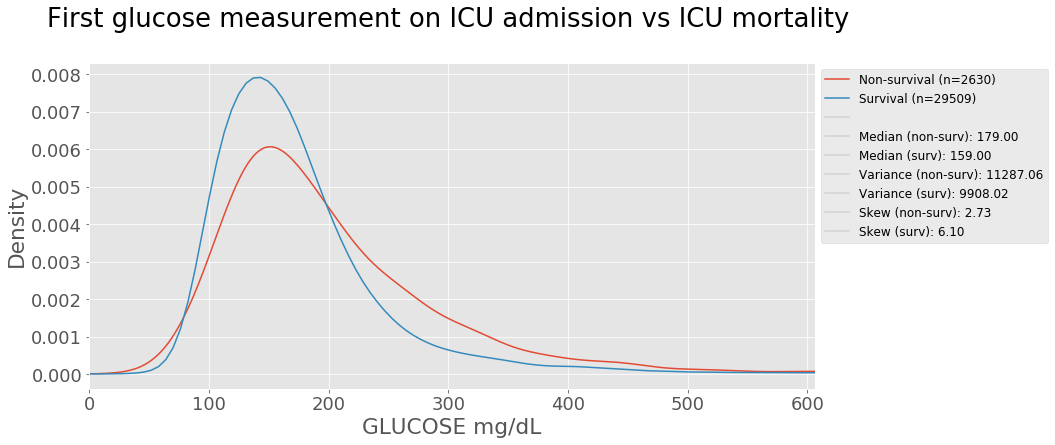

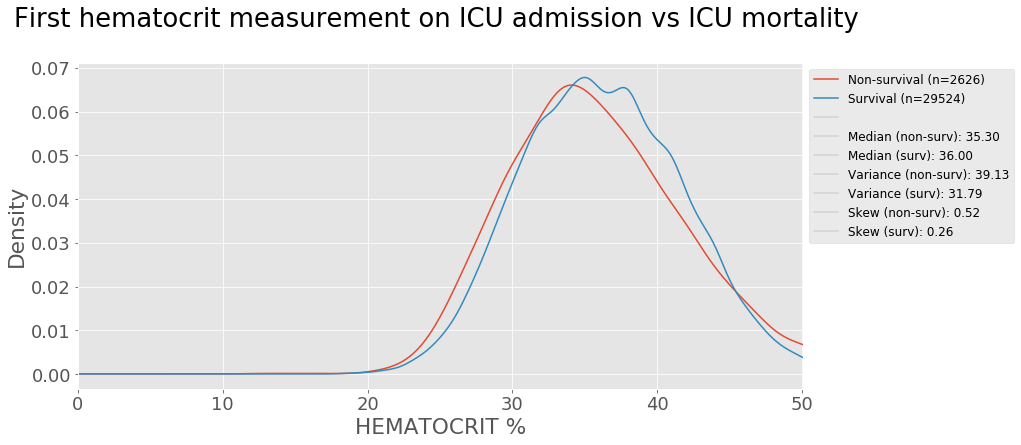

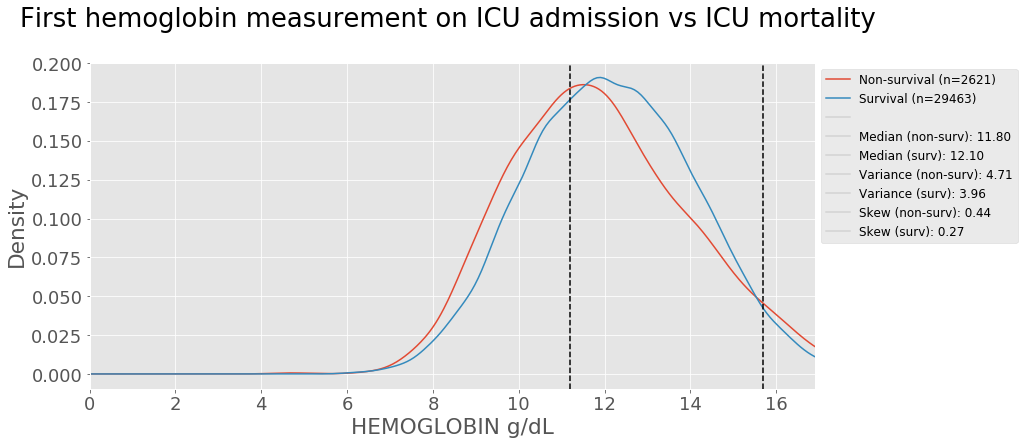

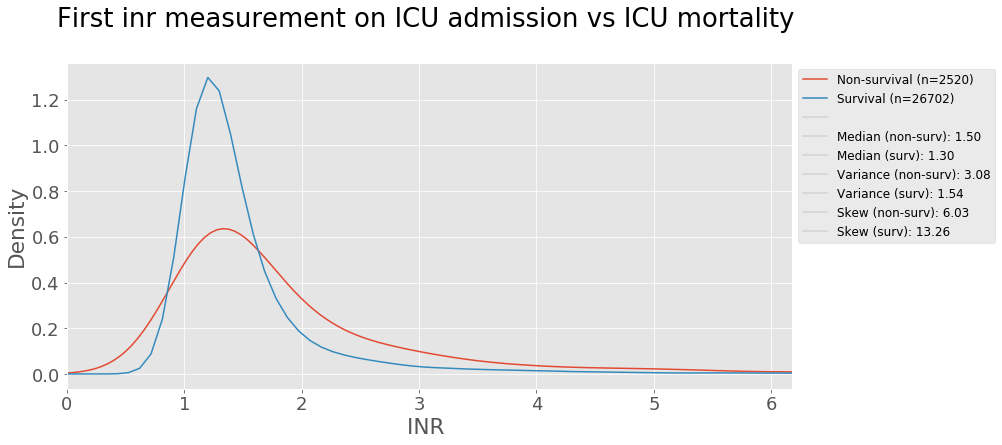

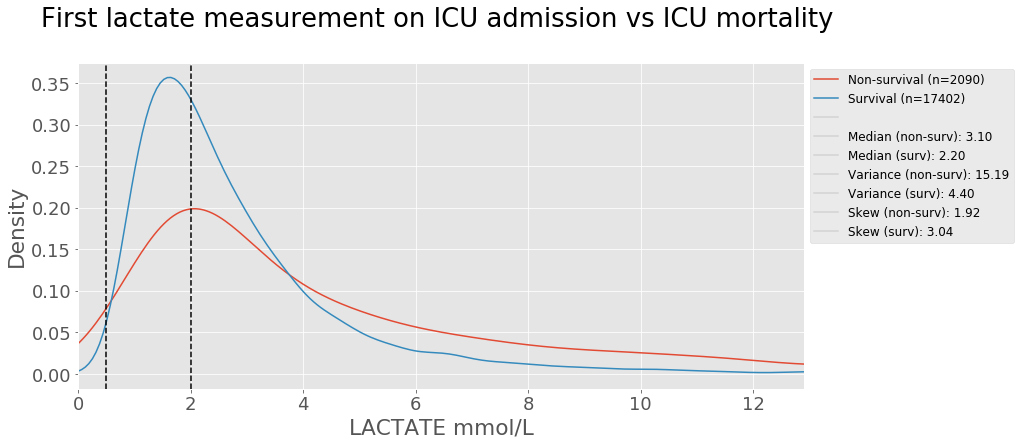

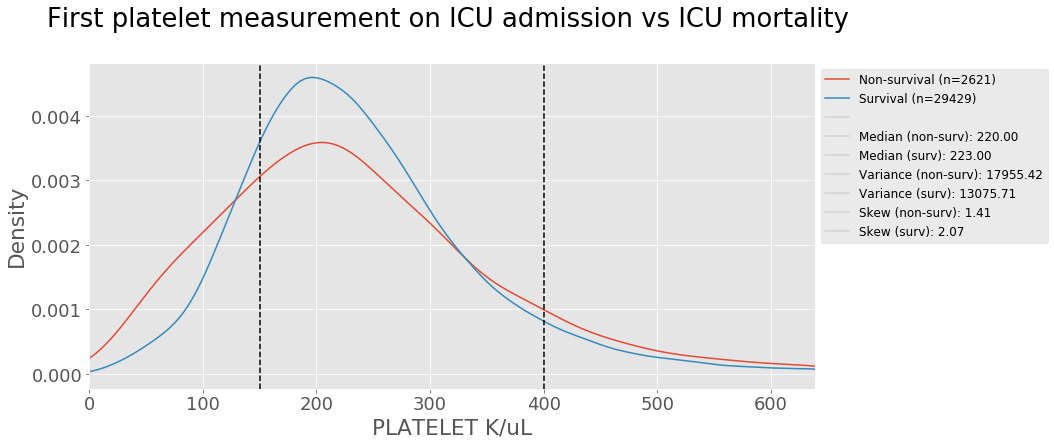

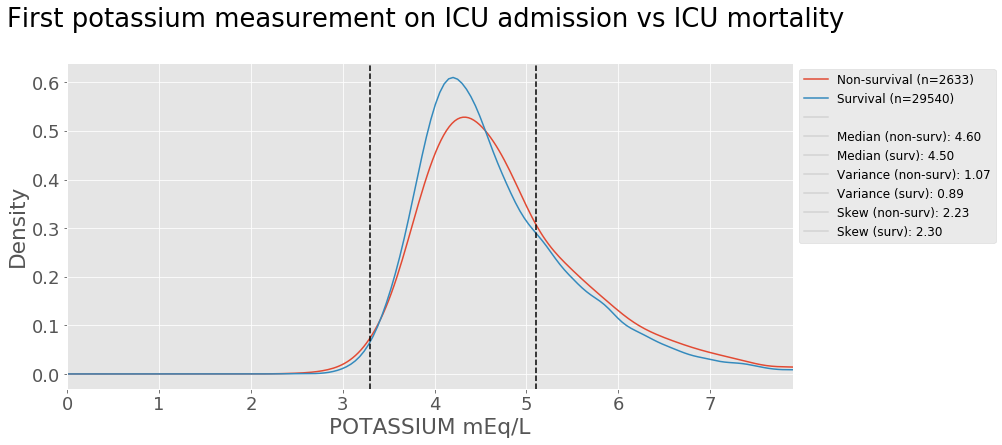

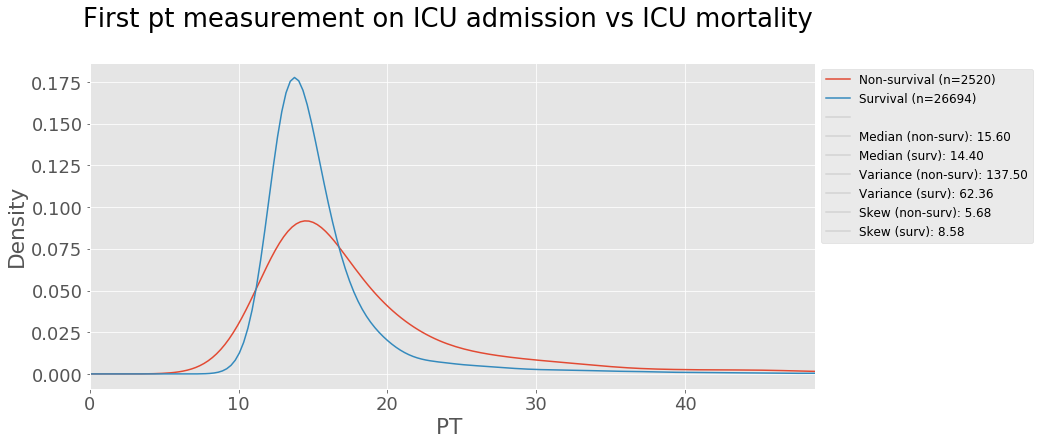

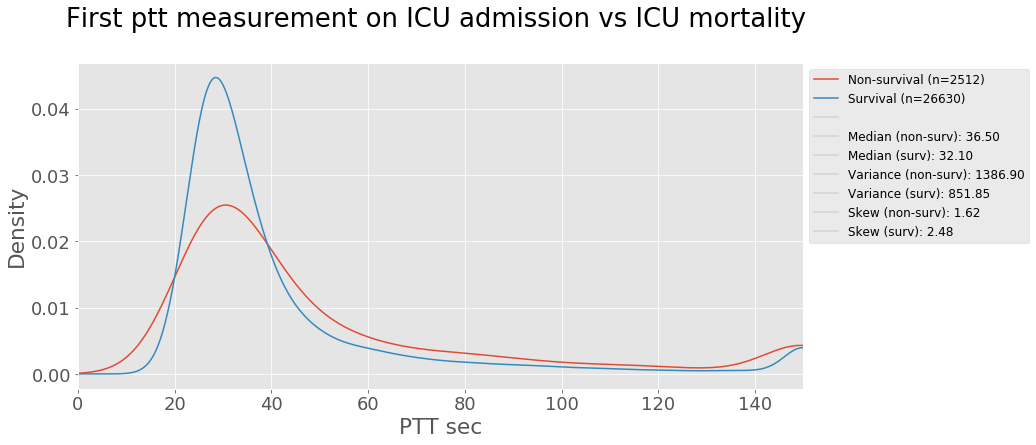

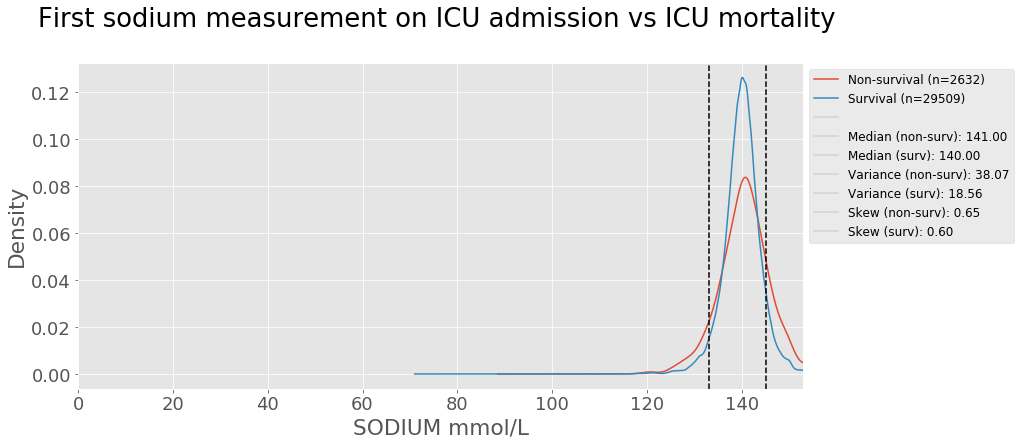

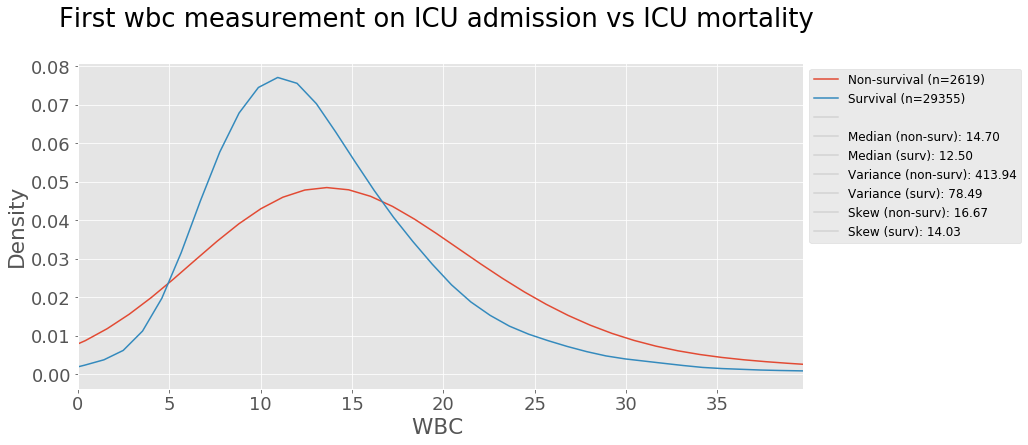

In [170]:
labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}

data = query_output

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().count()
    n_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().median()
    med_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().median()
    var_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().var()
    var_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().var()
    skew_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().skew()
    skew_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().skew() 
    
    # plot
    plt.subplots(figsize=(13,6))
    data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, data[l.lower()+'_max'].quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

## Mortality prediction

We'll now add a few additional mortality outcomes that we'll try to predict. Previously, we only look at whether the patient died in the hospital or not. We'll now try to be more specific and try to predict whether the patient died within the next 30 days and 1 year of being admitted to the hospital, and whether the patient died in the ICU. 

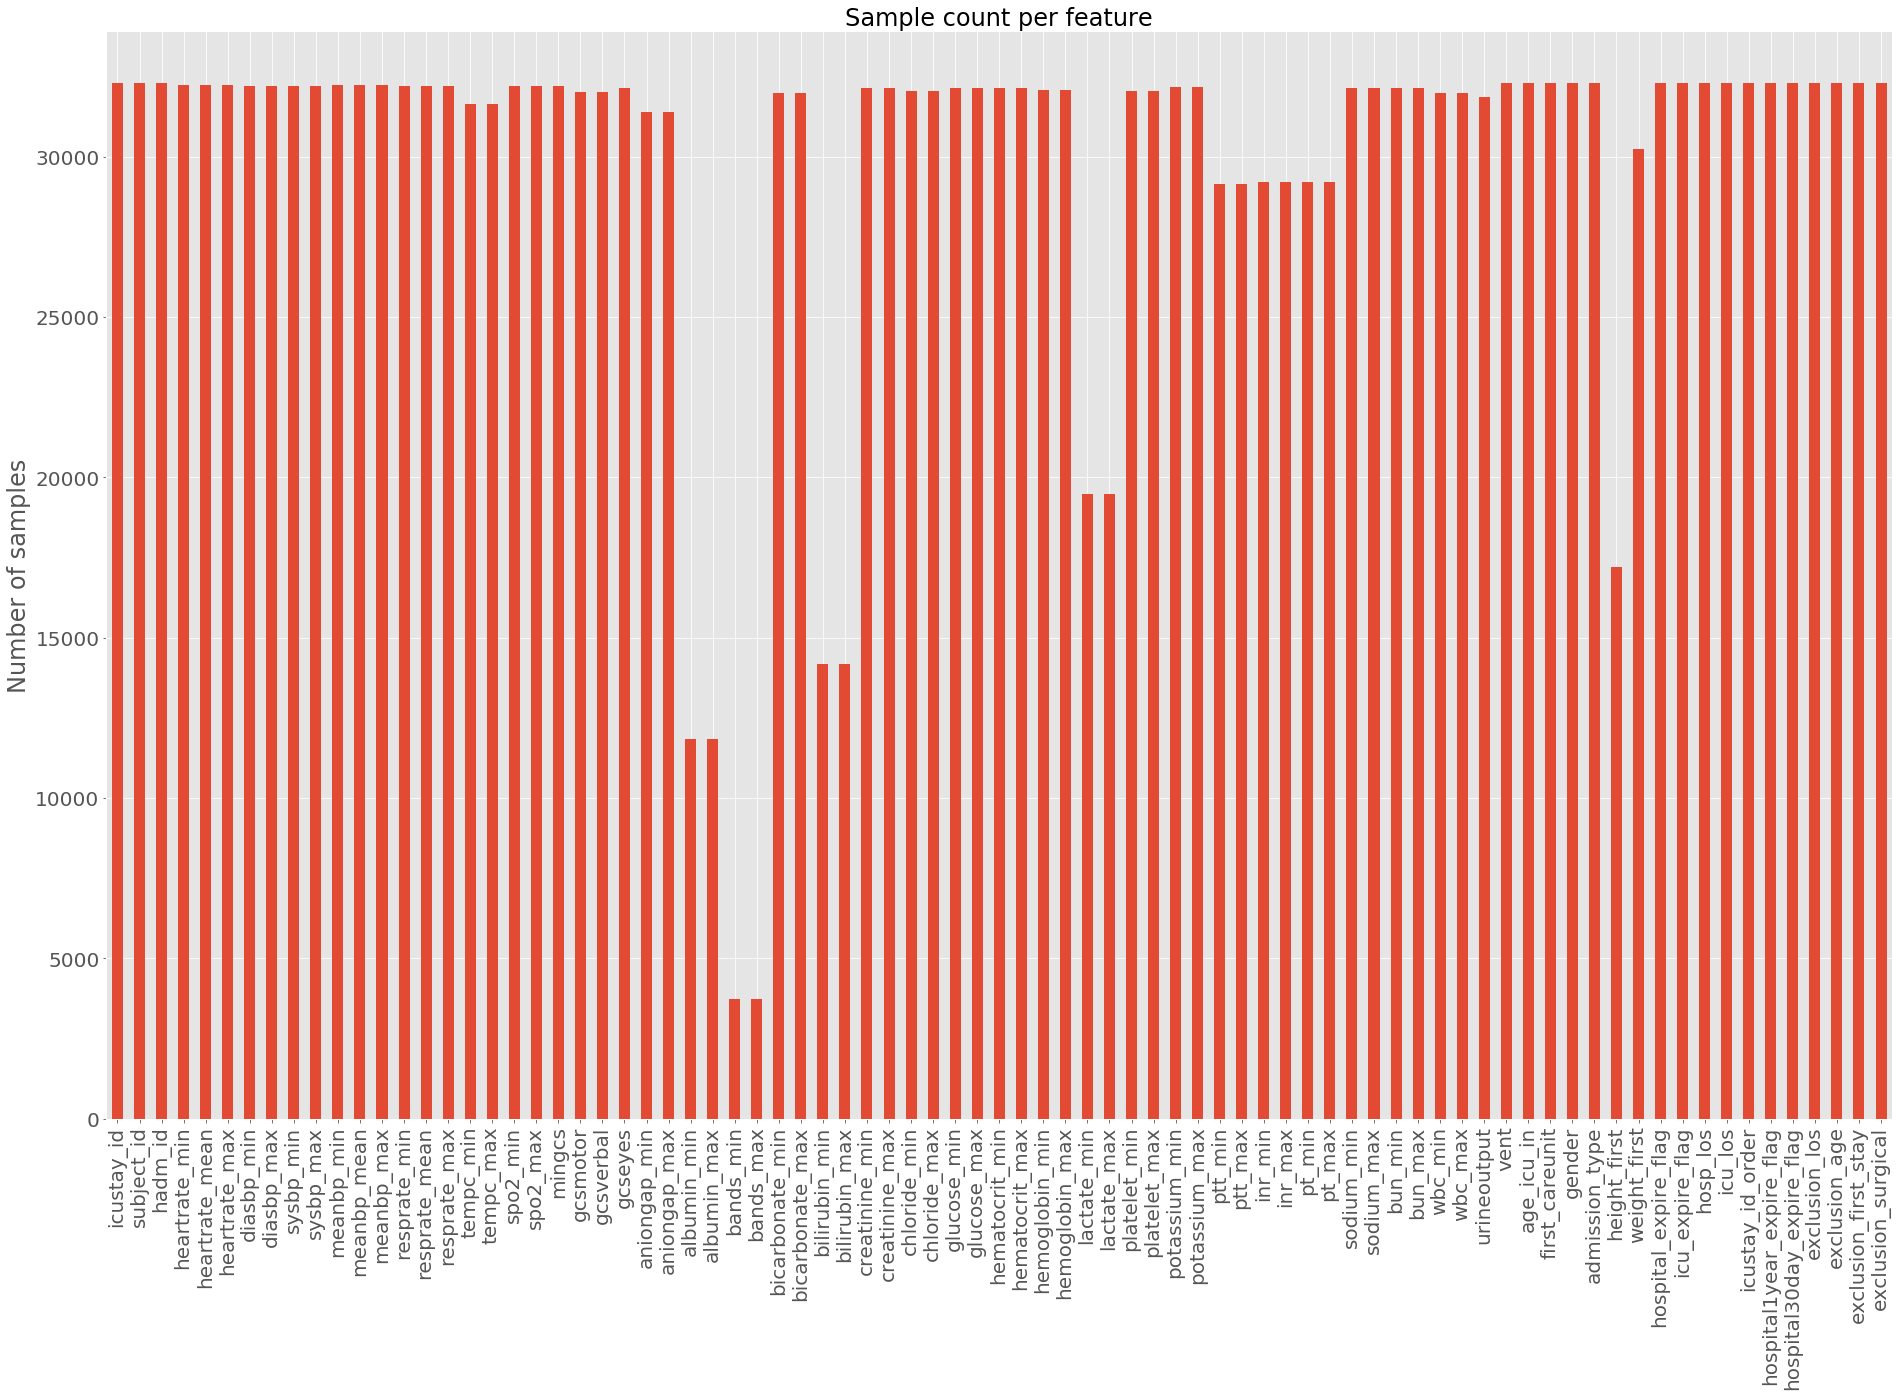

In [134]:
query_output = pd.read_csv('./full-features-materialized.csv') #.dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) & (query_output.exclusion_first_stay == 0)]

ax = query_output.count().plot.bar(figsize=(32, 20), fontsize=20)
ax.set_ylabel('Number of samples', fontsize=24)
ax.set_title('Sample count per feature', fontsize=24)

In [2]:
query_output = pd.read_csv('./full-features-materialized.csv') #.dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) 
                            & (query_output.exclusion_first_stay == 0) ]#& (query_output.age_icu_in < 250)]

# Median age of patients > 89 is 91.6
query_output.loc[query_output.age_icu_in > 89, 'age_icu_in'] = 91.6

mortality_names = ['hospital_expire_flag', 'icu_expire_flag', 
                   'hospital1year_expire_flag', 'hospital30day_expire_flag']

los_names = ['hosp_los', 'icu_los']

feature_names = [
            # Demographic information
            'age_icu_in', 'gender', 'first_careunit',
            'admission_type',
    
            # Vital signs
            'heartrate_min', 'heartrate_max', 
            'meanbp_min', 'meanbp_max', 
            'diasbp_min', 'diasbp_max',
            'sysbp_min', 'sysbp_max',
            'resprate_min', 'resprate_max',
            'mingcs', 'gcsmotor',
            'gcsverbal', 'gcseyes',             
            'tempc_min', 'tempc_max',
            'spo2_min', 'spo2_max',
                 
            # Laboratory measurements
            
            'aniongap_min', 'aniongap_max',
            #'albumin_min', 'albumin_max',
            #'bands_min', 'bands_max',
            'bicarbonate_min', 'bicarbonate_max',
            #'bilirubin_min', 'bilirubin_max',
            'creatinine_min', 'creatinine_max',
            'chloride_min', 'chloride_max',
            'glucose_min', 'glucose_max',
            'hematocrit_min', 'hematocrit_max',
            'hemoglobin_min', 'hemoglobin_max',
            #'lactate_min', 'lactate_max',
            'platelet_min', 'platelet_max',
            'potassium_min', 'potassium_max',
            #'ptt_min', 'ptt_max',
            #'inr_min', 'inr_max',
            #'pt_min', 'pt_max',
            'sodium_min', 'sodium_max',
            'bun_min', 'bun_max',
            'wbc_min', 'wbc_max',                 
            
            # Other
            'vent', 
            'urineoutput'
            ]

query_output = query_output.loc[:, mortality_names + feature_names]
query_output = query_output.fillna(query_output.mean()).reset_index(drop=True)

#query_output = query_output.loc[:, mortality_names + feature_names].dropna().reset_index(drop=True) # drop NaNs

outcomes = query_output.loc[:, mortality_names]
features = query_output.loc[:, query_output.columns.difference(mortality_names + los_names)]

X = features
y = outcomes['hospital_expire_flag'].replace(0, -1)

print(len(query_output))
query_output.tail()

32290


,hospital_expire_flag,icu_expire_flag,hospital1year_expire_flag,hospital30day_expire_flag,age_icu_in,gender,first_careunit,admission_type,heartrate_min,heartrate_max,...,potassium_min,potassium_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,vent,urineoutput
32285,0,0,0,0,70.826046,0,5,0,62.0,119.0,...,3.1,3.9,135.0,144.0,7.0,7.0,3.3,4.5,1,1995.0
32286,0,0,0,0,63.893494,0,2,1,60.0,95.0,...,3.5,3.9,139.0,143.0,16.0,31.0,5.3,8.6,0,1400.0
32287,0,0,0,0,43.594414,0,0,1,58.0,80.0,...,3.8,4.1,139.0,140.0,12.0,13.0,11.7,11.8,0,1250.0
32288,1,1,1,1,86.957864,1,2,1,52.0,68.0,...,5.0,5.7,123.0,128.0,41.0,42.0,11.4,13.3,1,730.0
32289,0,0,0,0,77.488270,1,0,1,28.0,74.0,...,4.4,4.9,135.0,138.0,21.0,22.0,10.8,11.0,0,1800.0


## 3D plot with 3 features

Although we now have a lot of features extracted, let's inspect how they might have an impact on mortality prediction. We'll use a 3D scatter plot to visualize age, heartrate and the Glasgow Coma Scale of patients.

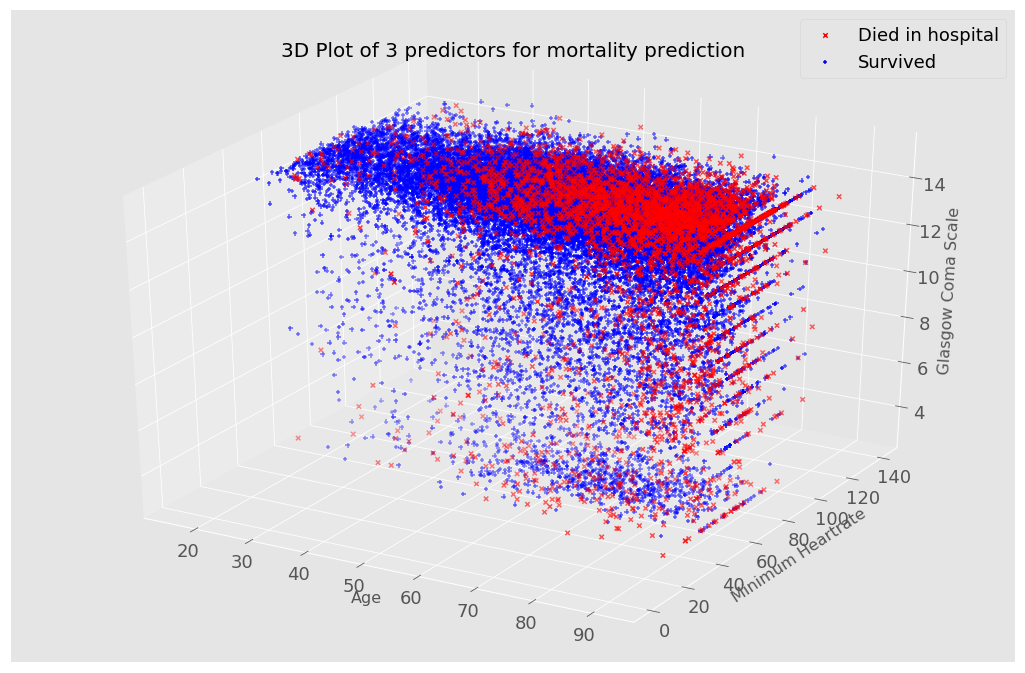

In [130]:
from mpl_toolkits.mplot3d import Axes3D

non_survival = query_output.loc[query_output.hospital_expire_flag == 1, ['age_icu_in', 'heartrate_min', 'mingcs', ]]
survival = query_output.loc[query_output.hospital_expire_flag == 0, ['age_icu_in', 'heartrate_min', 'mingcs', ]]

fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(non_survival.loc[:, non_survival.columns[0]], non_survival.loc[:, non_survival.columns[1]], 
           non_survival.loc[:, non_survival.columns[2]], c='red', marker='x', cmap='coolwarm', label='Died in hospital')
ax.scatter(survival.loc[:, survival.columns[0]], survival.loc[:, survival.columns[1]], 
           survival.loc[:, survival.columns[2]], c='blue', marker='+', cmap='coolwarm', label='Survived')

ax.set_xlabel('Age', fontsize=16)
ax.set_ylabel('Minimum Heartrate', fontsize=16)
ax.set_zlabel('Glasgow Coma Scale', fontsize=16)

ax.legend(loc='upper right', fontsize=18)
ax.set_title('3D Plot of 3 predictors for mortality prediction', fontsize=20)

plt.show()

## Data preprocessing

Because our features are quite different and vary in categories, we'll standardize the features by subtracting the mean and removing data with zerio variance.

In [6]:
split = int(len(X) * 0.7)

X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = BinaryLabels(np.array(y[:split]))
y_test = BinaryLabels(np.array(y[split:]))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

('Number of training samples:', 3500)
('Number of testing samples:', 1500)


In [7]:
preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

True

In [40]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train)
svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply(X_test)

#use AccuracyMeasure to get accuracy
acc = AccuracyMeasure()
acc.evaluate(y_pred, y_test)

accuracy = acc.get_accuracy() * 100
print('Accuracy(%):', accuracy)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test)

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Accuracy(%):', 90.05130492973456)
('Area under ROC(%):', 0.8456069935318584)
CPU times: user 2.3 s, sys: 1.27 s, total: 3.57 s
Wall time: 1.46 s


In [135]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train)
svm.set_liblinear_solver_type(L2R_LR)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply(X_test)

lr_roc = ROCEvaluation()
lr_roc.evaluate(y_pred, y_test)

auc = lr_roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.8314741069842869)
CPU times: user 3.2 s, sys: 3.25 s, total: 6.45 s
Wall time: 2.43 s


In [136]:
%%time
y_train = MulticlassLabels(np.array(y.replace(-1, 0)[:split].astype(np.float)))
y_test = MulticlassLabels(np.array(y.replace(-1, 0)[split:].astype(np.float)))

feature_types = np.zeros_like(features.columns, dtype=bool)
feature_types[np.where( (features.columns == 'admission_type') | (features.columns == 'first_careunit') |(features.columns == 'gender'))[0]] = True

m_vote = MajorityVote()

rand_forest = RandomForest(X_train, y_train, 100)
rand_forest.set_combination_rule(m_vote)
rand_forest.set_feature_types(feature_types)
rand_forest.train()

y_pred = rand_forest.apply_multiclass(X_test)

# Convert to BinaryLabels()
y_pred_bin = y_pred.get_labels()
y_pred_bin[y_pred_bin == 0] = -1
y_pred_bin = BinaryLabels(y_pred_bin)

y_test_bin = y_test.get_labels()
y_test_bin[y_test_bin == 0] = -1
y_test_bin = BinaryLabels(y_test_bin)

roc = ROCEvaluation()
roc.evaluate(y_pred_bin, y_test_bin)

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.5782253996539711)
CPU times: user 1min 25s, sys: 24 ms, total: 1min 25s
Wall time: 26.7 s


## XGBoost

In [11]:
split = int(len(X) * 0.7)

X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = np.array(y[:split])
y_test = np.array(y[split:])

print("Number of training samples:", y_train.shape)
print("Number of testing samples:", y_test.shape)

preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

X_train = X_train.get_feature_matrix().T
X_test = X_test.get_feature_matrix().T

xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

y_pred = xgboost.predict(X_test)
y_score = xgboost.predict_proba(X_test)

roc = ROCEvaluation()

roc.evaluate(BinaryLabels(y_score[:, 1].astype(np.float64)), BinaryLabels(y_test))

('Number of training samples:', (22603,))
('Number of testing samples:', (9687,))


0.8740083433960528

In [10]:
aucs = []
train_times = []
for i in range(k):
    train_idx = stratified_split.generate_subset_inverse(i)
    test_idx = stratified_split.generate_subset_indices(i)
    X_train = RealFeatures(np.array(X.loc[train_idx]).T)
    y_train = BinaryLabels(np.array(y.loc[train_idx]))    

    X_test = RealFeatures(np.array(X.loc[test_idx]).T)
    y_test = BinaryLabels(np.array(y.loc[test_idx]))

    preprocessor = PruneVarSubMean(True)
    preprocessor.init(X_train)
    X_train.add_preprocessor(preprocessor)
    X_train.apply_preprocessor(True)

    preprocessor.init(X_test)
    X_test.add_preprocessor(preprocessor)
    X_test.apply_preprocessor(True)

    tstart = time.time()
    
    X_train = X_train.get_feature_matrix().T
    X_test = X_test.get_feature_matrix().T

    xgboost = XGBClassifier()
    xgboost.fit(X_train, y_train)
    tend = time.time()
    
    y_pred = xgboost.predict(X_test)
    y_score = xgboost.predict_proba(X_test)

    roc = ROCEvaluation()
    roc.evaluate(BinaryLabels(y_score[:, 1].astype(np.float64)), y_test)
    auc = roc.get_auROC()
    print("Fold", i, " auROC(%): ", auc)    

    aucs.append(auc)
  
    train_time = tend - tstart
    train_times.append(train_time)
    
mean_auc = np.mean(aucs)
mean_train_time = np.mean(train_times)
print("Mean auROC across all folds:", mean_auc) 
print("Mean train time across all folds:", mean_train_time) 


('Fold', 0, ' auROC(%): ', 0.8697437933096114)
('Fold', 1, ' auROC(%): ', 0.8739680668140353)
('Fold', 2, ' auROC(%): ', 0.88102186195039)
('Fold', 3, ' auROC(%): ', 0.8636615797778954)
('Fold', 4, ' auROC(%): ', 0.8794890690247958)
('Fold', 5, ' auROC(%): ', 0.877221321542608)
('Fold', 6, ' auROC(%): ', 0.8774954556620037)
('Fold', 7, ' auROC(%): ', 0.8743325964136586)
('Fold', 8, ' auROC(%): ', 0.8905094571358179)
('Fold', 9, ' auROC(%): ', 0.8745841786977866)
('Mean auROC across all folds:', 0.8762027380328602)
('Mean train time across all folds:', 20.518986678123476)


## SKlearn

In [ ]:
%%time

split = int(len(X) * 0.7)

X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = np.array(y[:split])
y_test = np.array(y[split:])

print("Number of training samples:", y_train.shape)
print("Number of testing samples:", y_test.shape)

preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

X_train = X_train.get_feature_matrix().T
X_test = X_test.get_feature_matrix().T

svm = SVC(kernel='rbf', C=2, gamma=0.02, probability=True)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
y_score = svm.predict_proba(X_test)

roc = ROCEvaluation()

y_pred[y_pred == 0] = -1
y_test[y_test == 0] = -1

roc.evaluate(BinaryLabels(y_score[:, 1].astype(np.float64)), BinaryLabels(y_test))

('Number of training samples:', (22603,))
('Number of testing samples:', (9687,))


In [138]:
from sklearn import metrics

from sklearn.svm import SVC, LinearSVC

split = int(len(X) * 0.7)

X_train = np.array(X[:split])
X_test = np.array(X[split:])

y_train = np.array(y[:split])
y_test = np.array(y[split:])

clf =  LinearSVC(C=1.0, tol=0.001, dual=False)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_score = clf.decision_function(X_test)

svm_auc = metrics.roc_auc_score(y_test, y_score)

print("sklearn SVM AUC:", svm_auc)

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

rf_auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
print("sklearn Random forest AUC:", rf_auc)

('sklearn SVM AUC:', 0.84245413837250571)
('sklearn Random forest AUC:', 0.81507859058879462)


## Baseline method (random guess)

In [70]:
y_test = np.array(y[split:])

y_prob = np.zeros_like(y_test)
y_prob[:sum(y_test == 1)] = 1
np.random.shuffle(y_prob)

roc = ROCEvaluation()
roc.evaluate(BinaryLabels(y_prob), BinaryLabels(y_test))

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.4970067693533955)


## Stratified k-fold cross validation + sklearn comparison

In [27]:
%%time

features = RealFeatures(np.array(X))
labels = BinaryLabels(np.array(y))

# Parameters to svm
C = 0.1
epsilon = 0.001

k = 10
stratified_split = StratifiedCrossValidationSplitting(labels, k)

stratified_split.build_subsets()

results = {}
results['sg-lr'] = {}
results['sg-svm'] = {}
results['sk-lr'] = {}
results['sk-svm'] = {}

total_results = {}

shogun_classifiers = {"sg-lr": L2R_LR, "sg-svm": L2R_L2LOSS_SVC }#, "RBF": None } #,"LR": L2R_LR}
sklearn_classifiers = {"sk-lr": LogisticRegression(C=0.1, tol=0.001), "sk-svm": LinearSVC(C=0.1, tol=0.001) } #, "sk-rf": RandomForestClassifier()}
classifiers = {}
classifiers.update(shogun_classifiers)
classifiers.update(sklearn_classifiers)

print("Evaluating classifiers...")
y = outcomes['hospital_expire_flag'].replace(0, -1)

for clf_name in classifiers:
    results[clf_name]['aucs'] = []
    results[clf_name]['compute_times'] = []
    print(clf_name)
    for i in range(k):
        train_idx = stratified_split.generate_subset_inverse(i)
        test_idx = stratified_split.generate_subset_indices(i)
        X_train = RealFeatures(np.array(X.loc[train_idx]).T)
        y_train = BinaryLabels(np.array(y.loc[train_idx]))    

        X_test = RealFeatures(np.array(X.loc[test_idx]).T)
        y_test = BinaryLabels(np.array(y.loc[test_idx]))

        preprocessor = PruneVarSubMean(True)
        preprocessor.init(X_train)
        X_train.add_preprocessor(preprocessor)
        X_train.apply_preprocessor(True)

        preprocessor.init(X_test)
        X_test.add_preprocessor(preprocessor)
        X_test.apply_preprocessor(True)
        
        tstart = time.time()
        
        roc = ROCEvaluation()
        
        if clf_name in shogun_classifiers:
            if clf_name == "RBF":
                gauss_kernel = GaussianKernel(X_train, X_train, 15)
                clf = LibSVM(C, gauss_kernel, y_train)
                clf.set_epsilon(epsilon)

            else:
                clf = LibLinear(C, X_train, y_train)
                clf.set_liblinear_solver_type(classifiers[clf_name])
                clf.set_epsilon(epsilon)

            clf.train()
            y_pred = clf.apply(X_test)
            roc.evaluate(y_pred, y_test)

        else:
            clf = classifiers[clf_name]
            clf.fit(X_train.get_feature_matrix().T, y_train)
            
            y_prob = clf.decision_function(X_test.get_feature_matrix().T)
            y_pred = y_prob
            roc.evaluate(BinaryLabels(y_pred), y_test)

        tend = time.time()
        
        compute_time = tend - tstart
        

        auc = roc.get_auROC()
        print("Fold", i, " auROC(%): ", auc)    
        results[clf_name]['aucs'].append(auc)
        results[clf_name]['compute_times'].append(compute_time)

    mean_auc = np.mean(results[clf_name]['aucs'])
    mean_compute_time = np.mean(results[clf_name]['compute_times'])
    results[clf_name]['mean_compute_time'] = mean_compute_time
    results[clf_name]['mean_aucs'] = mean_auc
    print("Mean auROC across all folds for", clf_name, ":", mean_auc) 
    print("Mean compute time across all folds for", clf_name, ":", mean_compute_time, 'seconds')    

Evaluating classifiers...
sk-lr
('Fold', 0, ' auROC(%): ', 0.8475549005158369)
('Fold', 1, ' auROC(%): ', 0.8310469172193504)
('Fold', 2, ' auROC(%): ', 0.8579916482436728)
('Fold', 3, ' auROC(%): ', 0.8458924097273407)
('Fold', 4, ' auROC(%): ', 0.8708199459592113)
('Fold', 5, ' auROC(%): ', 0.8281768607221806)
('Fold', 6, ' auROC(%): ', 0.8493634038048712)
('Fold', 7, ' auROC(%): ', 0.8405030041067468)
('Fold', 8, ' auROC(%): ', 0.8599685580938478)
('Fold', 9, ' auROC(%): ', 0.8327374126456618)
('Mean auROC across all folds for', 'sk-lr', ':', 0.84640550610387211)
('Mean compute time across all folds for', 'sk-lr', ':', 0.74882323741912837, 'seconds')
sk-svm
('Fold', 0, ' auROC(%): ', 0.8463404568901907)
('Fold', 1, ' auROC(%): ', 0.8294453451240444)
('Fold', 2, ' auROC(%): ', 0.856530582166547)
('Fold', 3, ' auROC(%): ', 0.8477150577253706)
('Fold', 4, ' auROC(%): ', 0.8683841807909574)
('Fold', 5, ' auROC(%): ', 0.8259572586588076)
('Fold', 6, ' auROC(%): ', 0.8484989267546852)
('F

Evaluating classifiers...
SVM
('Fold', 0, ' auROC(%): ', 0.8362963843755996)
('Fold', 1, ' auROC(%): ', 0.839726853464006)
('Fold', 2, ' auROC(%): ', 0.8355724860808302)
('Fold', 3, ' auROC(%): ', 0.8289046110464412)
('Fold', 4, ' auROC(%): ', 0.8325690767133276)
('Fold', 5, ' auROC(%): ', 0.8420737737425964)
('Fold', 6, ' auROC(%): ', 0.8273180509431723)
('Fold', 7, ' auROC(%): ', 0.8092518197028787)
('Fold', 8, ' auROC(%): ', 0.8484367966434081)
('Fold', 9, ' auROC(%): ', 0.8385052570302208)
('Mean auROC across all folds for', 'SVM', ':', 0.8338655109742481)
LR
('Fold', 0, ' auROC(%): ', 0.836017802087655)
('Fold', 1, ' auROC(%): ', 0.8390185070367391)
('Fold', 2, ' auROC(%): ', 0.8367716370581115)
('Fold', 3, ' auROC(%): ', 0.8299450479450147)
('Fold', 4, ' auROC(%): ', 0.8325843958883327)
('Fold', 5, ' auROC(%): ', 0.8422559017121853)
('Fold', 6, ' auROC(%): ', 0.8278650234841343)
('Fold', 7, ' auROC(%): ', 0.8102939552739339)
('Fold', 8, ' auROC(%): ', 0.8490500174113808)
('Fold',

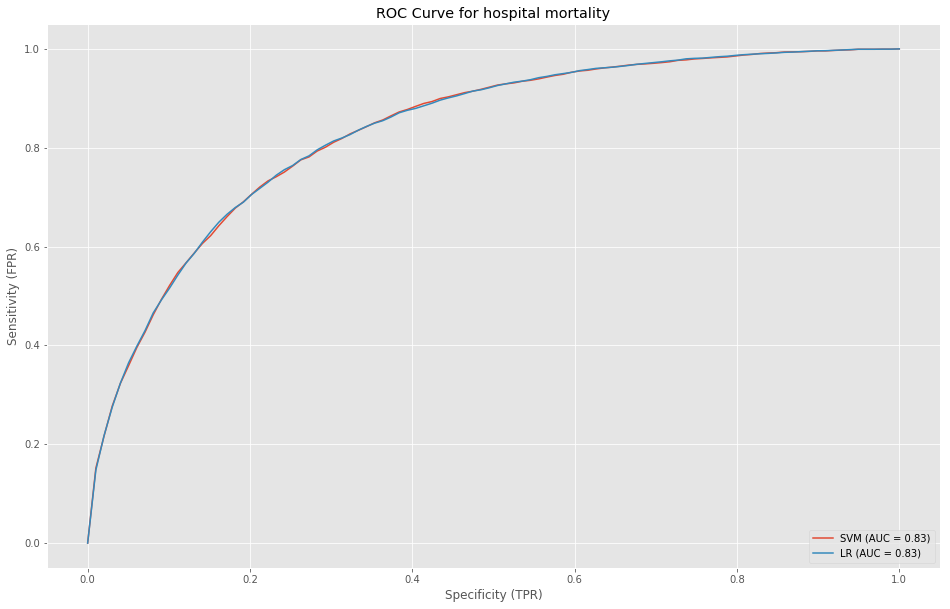

CPU times: user 50.6 s, sys: 53.6 s, total: 1min 44s
Wall time: 39.2 s


In [60]:
%%time

features = RealFeatures(np.array(X))
labels = BinaryLabels(np.array(y))

# Parameters to svm
C = 0.1
epsilon = 0.001

k = 10
stratified_split = StratifiedCrossValidationSplitting(labels, k)

metric = ROCEvaluation()

stratified_split.build_subsets()
results = {}
total_results = {}

classifiers = {"LR": L2R_LR, "SVM": L2R_L2LOSS_SVC }#, "RBF": None } #,"LR": L2R_LR}
print("Evaluating classifiers...")

mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(16, 10))

y = outcomes['hospital30day_expire_flag'].replace(0, -1)

for clf in classifiers:
    aucs = []
    print(clf)
    mean_tpr = 0.0
    for i in range(k):
        train_idx = stratified_split.generate_subset_inverse(i)
        test_idx = stratified_split.generate_subset_indices(i)
        X_train = RealFeatures(np.array(X.loc[train_idx]).T)
        y_train = BinaryLabels(np.array(y.loc[train_idx]))    

        X_test = RealFeatures(np.array(X.loc[test_idx]).T)
        y_test = BinaryLabels(np.array(y.loc[test_idx]))

        preprocessor = PruneVarSubMean(True)
        preprocessor.init(X_train)
        X_train.add_preprocessor(preprocessor)
        X_train.apply_preprocessor(True)

        preprocessor.init(X_test)
        X_test.add_preprocessor(preprocessor)
        X_test.apply_preprocessor(True)            

        if clf == "RBF":
            gauss_kernel = GaussianKernel(X_train, X_train, 15)
            svm = LibSVM(C, gauss_kernel, y_train)
            svm.set_epsilon(epsilon)

        else:
            svm = LibLinear(C, X_train, y_train)
            svm.set_liblinear_solver_type(classifiers[clf])
            svm.set_epsilon(epsilon)

        svm.train()

        y_pred = svm.apply(X_test)

        roc = ROCEvaluation()
        roc.evaluate(y_pred, y_test)

        auc = roc.get_auROC()
        print("Fold", i, " auROC(%): ", auc)    
        aucs.append(auc)

        fpr, tpr = roc.get_ROC()
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

    results[clf] = aucs
    print("Mean auROC across all folds for", clf, ":", np.mean(aucs))
    mean_tpr /= k
    mean_tpr[-1] = 1.0


    plt.plot(mean_fpr, mean_tpr, label='%s (AUC = %0.2f)' % (clf, np.mean(aucs)))

plt.title('ROC Curve for hospital mortality')
plt.xlabel('Specificity (TPR)')
plt.ylabel('Sensitivity (FPR)')
    
plt.legend(loc='lower right')
plt.rc('font', size=18)

plt.show()

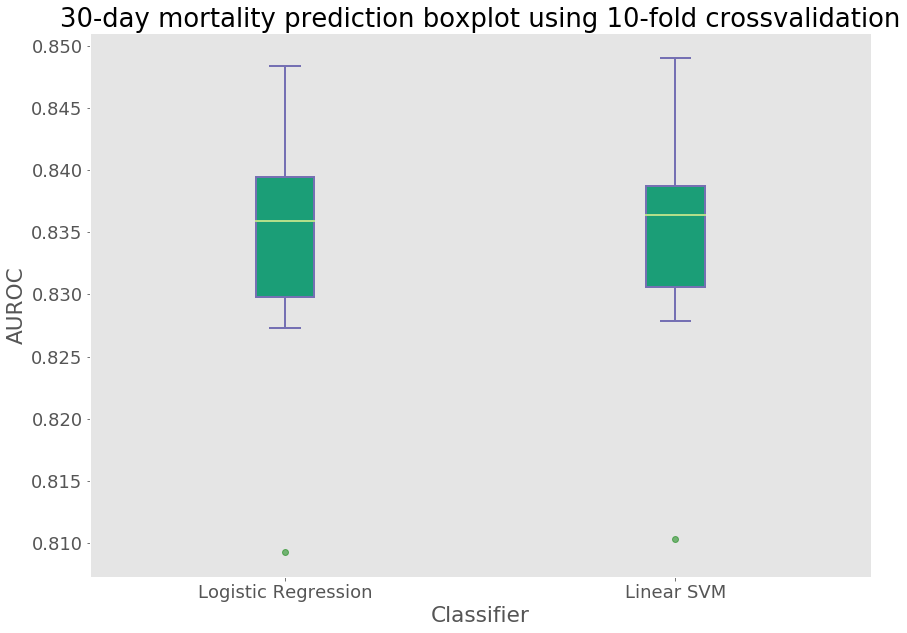

In [69]:
# styling taken from http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/

aucs = [results[clf] for clf in results]
data = np.array(aucs).T
xlabels = [clf for clf in results]

plt.figure(figsize=(14, 10))
bp = plt.boxplot(data, 0, 'gD', patch_artist=True)
plt.ylabel('AUROC')
plt.xlabel('Classifier')
plt.xticks([1, 2], [ 'Logistic Regression', 'Linear SVM',])
plt.title('30-day mortality prediction boxplot using 10-fold crossvalidation')
plt.grid(b=False)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
    
plt.show()

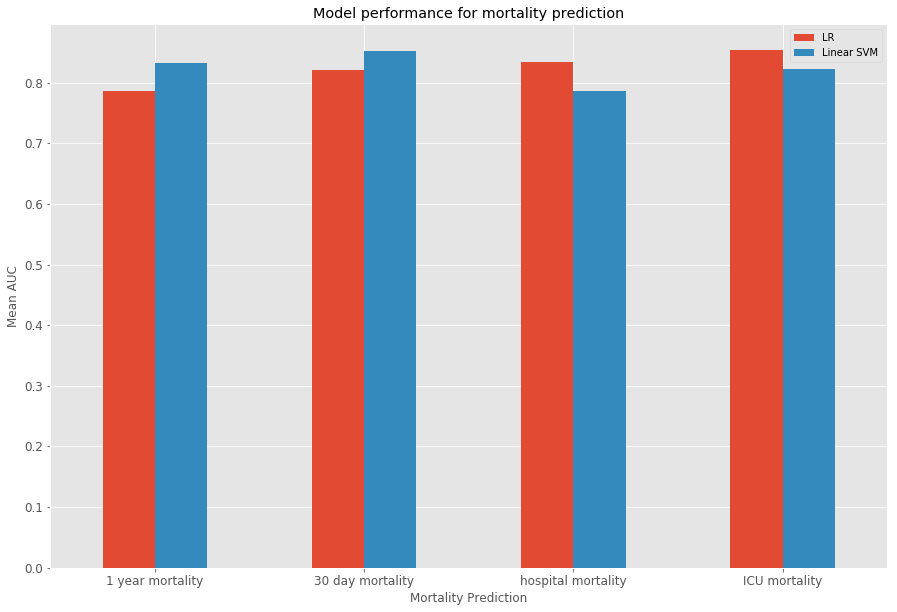

In [130]:
lr_df = pd.DataFrame(lr_results).describe().loc['mean', :]
svm_df = pd.DataFrame(svm_results).describe().loc['mean', :]
results_df = pd.concat((lr_df, svm_df), axis=1, keys=['LR', 'Linear SVM'])
ax = results_df.plot.bar(figsize=(15,10), fontsize=12, title='Model performance for mortality prediction')
ax.set_ylabel('Mean AUC')
ax.set_xticklabels(['1 year mortality', '30 day mortality', 'hospital mortality', 'ICU mortality'], rotation=0)
ax.set_xlabel('Mortality Prediction')

## Length of stay

In [123]:
query_output = pd.read_csv('./full-features-materialized.csv') #.dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) & (query_output.exclusion_first_stay == 0)]

los_names = ['hosp_los', 'icu_los']

feature_names = [
            # Demographic information
            'age_icu_in', 'gender', 'first_careunit',
            'admission_type',
    
            # Vital signs
            'heartrate_min', 'heartrate_max', 
            'meanbp_min', 'meanbp_max', 
            'diasbp_min', 'diasbp_max',
            'sysbp_min', 'sysbp_max',
            'resprate_min', 'resprate_max',
            'mingcs', 'gcsmotor',
            'gcsverbal', 'gcseyes',             
            'tempc_min', 'tempc_max',
            'spo2_min', 'spo2_max',
                 
            # Laboratory measurements
            
            'aniongap_min', 'aniongap_max',
            #'albumin_min', 'albumin_max',
            #'bands_min', 'bands_max',
            'bicarbonate_min', 'bicarbonate_max',
            #'bilirubin_min', 'bilirubin_max',
            'creatinine_min', 'creatinine_max',
            'chloride_min', 'chloride_max',
            'glucose_min', 'glucose_max',
            'hematocrit_min', 'hematocrit_max',
            'hemoglobin_min', 'hemoglobin_max',
            #'lactate_min', 'lactate_max',
            'platelet_min', 'platelet_max',
            'potassium_min', 'potassium_max',
            #'ptt_min', 'ptt_max',
            #'inr_min', 'inr_max',
            #'pt_min', 'pt_max',
            'sodium_min', 'sodium_max',
            'bun_min', 'bun_max',
            'wbc_min', 'wbc_max',                 
            
            # Other
            'vent', 
            'urineoutput'
            ]

query_output = query_output.loc[:, los_names + feature_names]
query_output = query_output.fillna(query_output.mean()).reset_index(drop=True)

#query_output = query_output.loc[:, los_names + feature_names].dropna().reset_index(drop=True)

outcomes = query_output.loc[:, los_names]
features = query_output.loc[:, query_output.columns.difference(los_names)]

X = features
y = outcomes['hosp_los']

print(len(query_output))
query_output.tail()

32290


,hosp_los,icu_los,age_icu_in,gender,first_careunit,admission_type,heartrate_min,heartrate_max,meanbp_min,meanbp_max,...,potassium_min,potassium_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,vent,urineoutput
32285,9.2917,3.8486,70.826046,0,5,0,62.0,119.0,71.0,118.0,...,3.1,3.9,135.0,144.0,7.0,7.0,3.3,4.5,1,1995.0
32286,3.1743,3.1737,63.893494,0,2,1,60.0,95.0,57.0,79.0,...,3.5,3.9,139.0,143.0,16.0,31.0,5.3,8.6,0,1400.0
32287,2.2396,1.2625,43.594414,0,0,1,58.0,80.0,49.0,105.0,...,3.8,4.1,139.0,140.0,12.0,13.0,11.7,11.8,0,1250.0
32288,9.0653,9.1439,86.957864,1,2,1,52.0,68.0,47.0,79.0,...,5.0,5.7,123.0,128.0,41.0,42.0,11.4,13.3,1,730.0
32289,1.6764,1.7034,77.488270,1,0,1,28.0,74.0,37.0,93.0,...,4.4,4.9,135.0,138.0,21.0,22.0,10.8,11.0,0,1800.0


In [124]:
split = int(len(X) * 0.7)

X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = RegressionLabels(np.array(y[:split]))
y_test = RegressionLabels(np.array(y[split:]))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

('Number of training samples:', 22603)
('Number of testing samples:', 9687)


In [125]:
preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

True

In [126]:
%%time

# Load models
ls = LeastSquaresRegression(X_train, y_train)

tau = 1
rr = LinearRidgeRegression(tau, X_train, y_train)

# Train
ls.train()
rr.train()

metric = MeanSquaredError()

y_pred = ls.apply_regression(X_test)
mse = metric.evaluate(y_pred, y_test)
print("Least square regression MSE:", mse)
y_pred = rr.apply_regression(X_test)
mse = metric.evaluate(y_pred, y_test)
print("Linear ridge regression MSE:", mse)

('Least square regression MSE:', 107.92233811641616)
('Linear ridge regression MSE:', 107.92209858555722)
CPU times: user 296 ms, sys: 0 ns, total: 296 ms
Wall time: 122 ms


## Baseline method (mean of training data)

In [132]:
metric = MeanSquaredError()

y_pred = np.random.normal(y_train.get_labels().mean(), 1, y_test.get_num_labels())

mse = metric.evaluate(RegressionLabels(y_pred), y_test)
print("Baseline MSE:", mse)

('Baseline MSE:', 114.30290209861074)


## With cross-validation

In [209]:
%%time

features = RealFeatures(np.array(X))
labels = RegressionLabels(np.array(y))

# Parameters to svm
k = 10
split = CrossValidationSplitting(labels, k)

metric = ROCEvaluation()
split.build_subsets()

classifiers = {'LSR': LeastSquaresRegression(), 'LLR': LinearRidgeRegression()}
tau = 1

regression_results = {}
total_regression_results = {}
total_regression_results['LSR'] = {}
total_regression_results['LLR'] = {}

print("Evaluating classifiers...")
for clf in classifiers:
    for outcome in los_names:
        y = outcomes[outcome]

        mses = []
        for i in range(k):    
            train_idx = split.generate_subset_inverse(i)
            test_idx = split.generate_subset_indices(i)
            X_train = RealFeatures(np.array(X.loc[train_idx]).T)
            y_train = RegressionLabels(np.array(y.loc[train_idx]))    
            X_test = RealFeatures(np.array(X.loc[test_idx]).T)
            y_test = RegressionLabels(np.array(y.loc[test_idx]))

            preprocessor = PruneVarSubMean(True)
            preprocessor.init(X_train)
            X_train.add_preprocessor(preprocessor)
            X_train.apply_preprocessor(True)

            preprocessor.init(X_test)
            X_test.add_preprocessor(preprocessor)
            X_test.apply_preprocessor(True)            
            
            if clf == 'LLR':
                classifiers[clf].set_tau(tau)

            classifiers[clf].set_features(X_train)
            classifiers[clf].set_labels(y_train)
            #ls = LeastSquaresRegression(X_train, y_train)

            classifiers[clf].train()

            metric = MeanSquaredError()

            y_pred = classifiers[clf].apply_regression(X_test)
            mse = metric.evaluate(y_pred, y_test)
            print("Fold %d, %s MSE:" % (i, clf), mse)
            mses.append(mse)
        regression_results[clf] = mses
        print('%s, Mean MSE across all folds:' % clf, np.mean(mses))
        total_regression_results[clf][outcome] = mses

Evaluating classifiers...
('Fold 0, LLR MSE:', 123.14707663803662)
('Fold 1, LLR MSE:', 218.76197058101235)
('Fold 2, LLR MSE:', 132.19235132882204)
('Fold 3, LLR MSE:', 214.47576622886518)
('Fold 4, LLR MSE:', 126.87365677624723)
('Fold 5, LLR MSE:', 191.97325104434447)
('Fold 6, LLR MSE:', 121.41371100028189)
('Fold 7, LLR MSE:', 204.93535590872125)
('Fold 8, LLR MSE:', 105.0355168232976)
('Fold 9, LLR MSE:', 219.15543036717736)
('LLR, Mean MSE across all folds:', 165.7964086696806)
('Fold 0, LLR MSE:', 43.393979516009594)
('Fold 1, LLR MSE:', 51.49980387796017)
('Fold 2, LLR MSE:', 36.21871723318467)
('Fold 3, LLR MSE:', 51.25985623839884)
('Fold 4, LLR MSE:', 42.88844294421598)
('Fold 5, LLR MSE:', 50.10696086765943)
('Fold 6, LLR MSE:', 37.751154737327454)
('Fold 7, LLR MSE:', 53.311423158990856)
('Fold 8, LLR MSE:', 31.99843901048221)
('Fold 9, LLR MSE:', 49.78290658035766)
('LLR, Mean MSE across all folds:', 44.82116841645869)
('Fold 0, LSR MSE:', 123.14705080805079)
('Fold 1, L